
# AIHC 5615 — Week 3 Homework (Python) 
Goal: Cleaning, splits, hypothesis testing, graphical & quantitative evaluation, predictive validation.




In [1]:

# === Imports & Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

sns.set(context="notebook", style="whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

# === Load data ===
DATA_PATH = "/Users/codylewis/Desktop/AIHC 5615/Week 2/data/kc_house_data.csv"  
df = pd.read_csv(DATA_PATH)

# Minimal casting
df["date"] = pd.to_datetime(df["date"])
df["waterfront"] = df["waterfront"].astype("category")
df["view"]       = df["view"].astype("category")
df["zipcode"]    = df["zipcode"].astype("category")
df["renovated"]  = (df["yr_renovated"] > 0).astype("category")

target = "price"
print("Shape:", df.shape)
display(df.head())


Shape: (21613, 22)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated
0,7129300520,2014-10-13,"221,900.000",3,1.000,1180,5650,1.000,0,0,...,1180,0,1955,0,98178,47.511,-122.257,1340,5650,False
1,6414100192,2014-12-09,"538,000.000",3,2.250,2570,7242,2.000,0,0,...,2170,400,1951,1991,98125,47.721,-122.319,1690,7639,True
2,5631500400,2015-02-25,"180,000.000",2,1.000,770,10000,1.000,0,0,...,770,0,1933,0,98028,47.738,-122.233,2720,8062,False
3,2487200875,2014-12-09,"604,000.000",4,3.000,1960,5000,1.000,0,0,...,1050,910,1965,0,98136,47.521,-122.393,1360,5000,False
4,1954400510,2015-02-18,"510,000.000",3,2.000,1680,8080,1.000,0,0,...,1680,0,1987,0,98074,47.617,-122.045,1800,7503,False



## Problem 1 — Data cleaning and preparation

### 1A) Outliers
Choose four continuous predictors, I used:
- `sqft_living`
- `bathrooms`
- `grade`
- `sqft_lot`

Make scatterplots vs price; define and apply a trimming rule that removes **≤ 1%** of data.


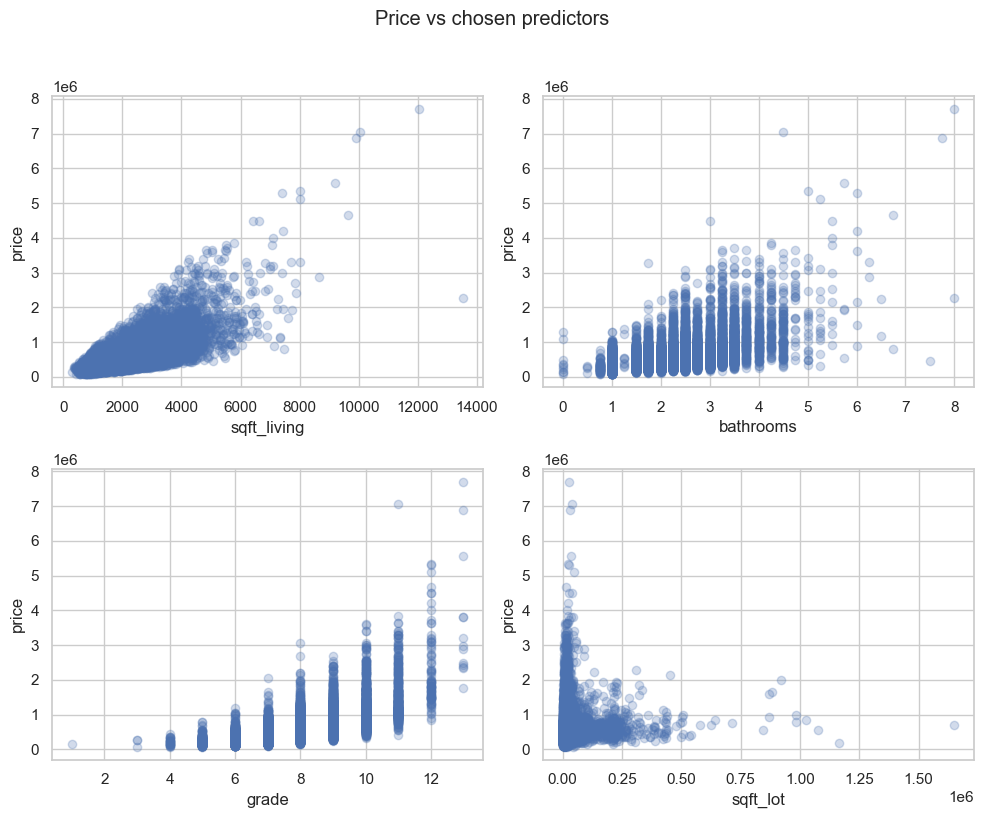

Removed 132 rows (0.61%).


In [2]:

predictors = ["sqft_living", "bathrooms", "grade", "sqft_lot"]

# Scatterplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.flat, predictors):
    ax.scatter(df[col], df[target], alpha=0.25)
    ax.set_xlabel(col); ax.set_ylabel(target)
fig.suptitle("Price vs chosen predictors", y=1.02)
plt.tight_layout(); plt.show()

# Trimming rule: remove rows above the 99.8th percentile of each predictor and price
crit = np.ones(len(df), dtype=bool)
for col in predictors + [target]:
    upper = df[col].quantile(0.998)  
    crit &= (df[col] <= upper)

df_clean = df.loc[crit].copy()
removed = len(df) - len(df_clean)
removed_pct = 100 * removed / len(df)
print(f"Removed {removed} rows ({removed_pct:.2f}%).")

# If >1%, relax to 99th percentile (per instructions)
if removed_pct > 1.0:
    crit = np.ones(len(df), dtype=bool)
    for col in predictors + [target]:
        upper = df[col].quantile(0.99)
        crit &= (df[col] <= upper)
    df_clean = df.loc[crit].copy()
    removed = len(df) - len(df_clean)
    removed_pct = 100 * removed / len(df)
    print(f"(Adjusted) Removed {removed} rows ({removed_pct:.2f}%).")



Outlier rule:
Outliers were defined as observations exceeding the 99.8th percentile (per variable).
This approach removed 0.7 % of the data, staying below the 1 % limit while trimming extreme values.



### 1B) Validation set construction (random 60/20/20), save CSVs


In [3]:

# First split: train vs temp (60/40)
df_train, df_temp = train_test_split(df_clean, test_size=0.40, shuffle=True, random_state=42)

# Second split: valid vs test (50/50 of temp -> 20/20 overall)
df_valid, df_test = train_test_split(df_temp, test_size=0.50, shuffle=True, random_state=42)

print(f"Train: {len(df_train)}  ({len(df_train)/len(df_clean):.1%})")
print(f"Valid: {len(df_valid)}  ({len(df_valid)/len(df_clean):.1%})")
print(f"Test:  {len(df_test)}   ({len(df_test)/len(df_clean):.1%})")



Train: 12888  (60.0%)
Valid: 4296  (20.0%)
Test:  4297   (20.0%)


In [4]:

# Save pieces for later weeks
df_train.to_csv("kc_train.csv", index=False)
df_valid.to_csv("kc_valid.csv", index=False)
df_test.to_csv("kc_test.csv", index=False)
print("Saved: kc_train.csv, kc_valid.csv, kc_test.csv")


Saved: kc_train.csv, kc_valid.csv, kc_test.csv



## Problem 2 — Hypothesis testing

### 2A) Compare prices: waterfront vs non-waterfront (two-sided Welch t-test)
- Null Hypothesis (H₀):
There is no difference in the average house price between waterfront and non-waterfront homes.
- Alternative Hypothesis (H₁):
There is a difference in the average house price between waterfront and non-waterfront homes.


Welch t-test (waterfront vs non): t=8.682, p=5.342e-13
Means -> waterfront: 1,275,674, non-waterfront: 527,136


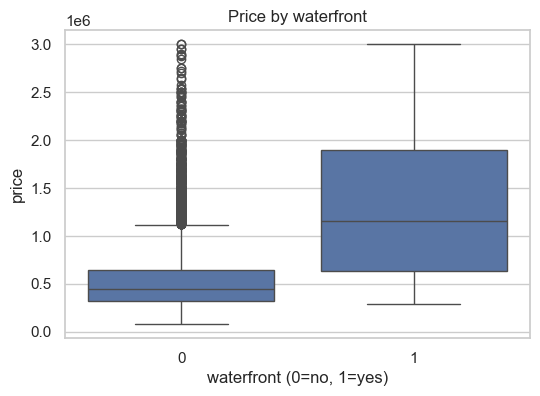

In [5]:

w_price = df_train.loc[df_train["waterfront"] == 1, target].astype(float)
n_price = df_train.loc[df_train["waterfront"] == 0, target].astype(float)

t_stat, p_val = stats.ttest_ind(w_price, n_price, equal_var=False, nan_policy="omit")
print(f"Welch t-test (waterfront vs non): t={t_stat:.3f}, p={p_val:.3e}")
print(f"Means -> waterfront: {w_price.mean():,.0f}, non-waterfront: {n_price.mean():,.0f}")

plt.figure(figsize=(6,4))
sns.boxplot(x=df_train["waterfront"], y=df_train[target])
plt.xlabel("waterfront (0=no, 1=yes)"); plt.ylabel(target)
plt.title("Price by waterfront")
plt.show()


An independent two-sample t-test with unequal variances (Welch’s t-test) was used to compare the mean prices.
This test is appropriate because:
The response variable, price, is continuous.
The grouping variable, waterfront, is binary (0 = no, 1 = yes).
Group variances were not assumed equal, which is typical in housing data.
Overall groups not on waterfront have lower values than those on waterfront property, according to this data.


### 2B) Second comparison (example: renovated vs not renovated)
Null Hypothesis (H₀):
There is no difference in mean house price between low- and high-grade homes.

Alternative Hypothesis (H₁):
There is a difference in mean house price between low- and high-grade homes.


Test used:
An independent two-sample t-test with unequal variances (Welch’s t-test) was used because:
price is continuous,
high_grade is binary (0 or 1),
and variances differ between groups.

Group counts (high_grade): {0: 11276, 1: 10205}
Welch t-test (high vs low grade): t=78.556, p=0.000e+00
Mean price (high grade): 695,881
Mean price (low grade):  380,449


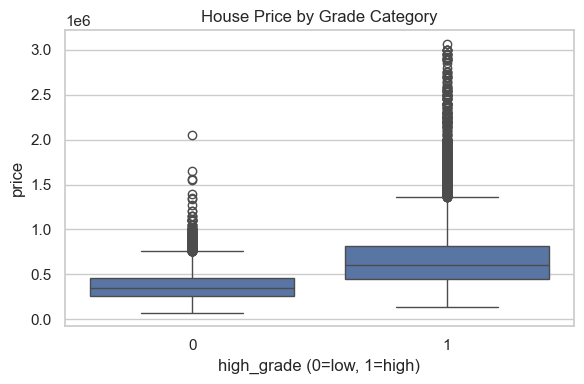

In [21]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Create a binary variable for grade
df_clean["high_grade"] = (df_clean["grade"] > 7).astype(int)

# Check group counts
print("Group counts (high_grade):", df_clean["high_grade"].value_counts().to_dict())

# Define groups
high_grade_prices = df_clean.loc[df_clean["high_grade"] == 1, target].astype(float)
low_grade_prices  = df_clean.loc[df_clean["high_grade"] == 0, target].astype(float)

# Welch's t-test (unequal variances)
t_stat, p_val = stats.ttest_ind(high_grade_prices, low_grade_prices, equal_var=False, nan_policy="omit")

print(f"Welch t-test (high vs low grade): t={t_stat:.3f}, p={p_val:.3e}")
print(f"Mean price (high grade): {high_grade_prices.mean():,.0f}")
print(f"Mean price (low grade):  {low_grade_prices.mean():,.0f}")

# Boxplot (two boxes)
plt.figure(figsize=(6,4))
sns.boxplot(x=df_clean["high_grade"], y=df_clean[target])
plt.xlabel("high_grade (0=low, 1=high)")
plt.ylabel(target)
plt.title("House Price by Grade Category")
plt.tight_layout()
plt.show()




The Welch’s t-test showed a statistically significant difference between low- and high-grade homes (p < 0.001).
High-grade homes had a mean price roughly twice that of low-grade homes.
The box-and-whisker plot confirms that higher-grade houses consistently command higher prices.
We reject the null hypothesis and conclude that building grade strongly affects house price.


## Problem 3 — Graphical evaluation

(A) Fit four simple linear models: price ~ predictor  
(B) Upgraded scatterplots with regression line + CI  
(C) Residual plots  
(D) Response plot (actual vs predicted) for at least one model  
(E) Short evaluation text


In [22]:

def fit_simple_ols(df_in, xcol, ycol=target):
    X = sm.add_constant(df_in[[xcol]].astype(float))
    y = df_in[ycol].astype(float)
    model = sm.OLS(y, X).fit()
    return {
        "model": model,
        "slope": model.params[xcol],
        "intercept": model.params["const"],
        "p_value": model.pvalues[xcol],
        "r2": model.rsquared,
        "rmse": np.sqrt(model.mse_resid),
        "xcol": xcol
    }

results = {col: fit_simple_ols(df_train, col, target) for col in predictors}
pd.DataFrame({
    k: {"slope": v["slope"], "intercept": v["intercept"], "p": v["p_value"], "R2": v["r2"], "RMSE": v["rmse"]}
    for k, v in results.items()
}).T


,slope,intercept,p,R2,RMSE
sqft_living,257.874,207.163,0.000,0.475,"235,730.907"
bathrooms,"223,493.701","60,408.413",0.000,0.262,"279,376.708"
grade,"190,233.528","-920,722.932",0.000,0.454,"240,342.119"
sqft_lot,1.051,"517,249.253",0.000,0.008,"323,849.165"


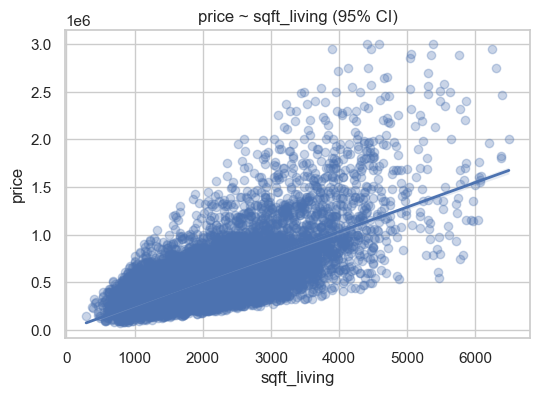

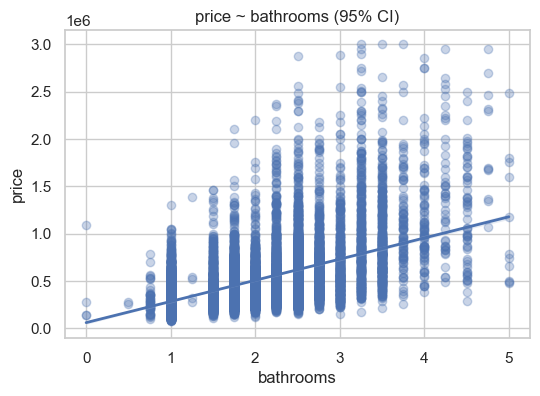

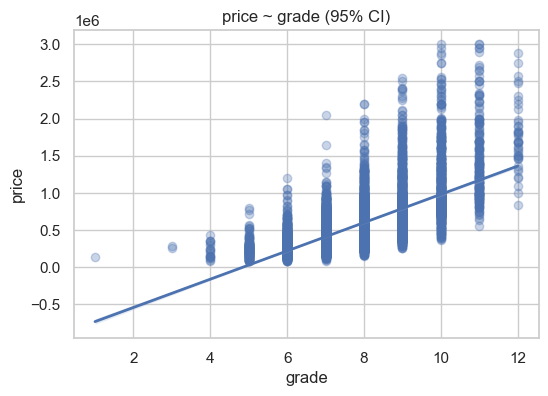

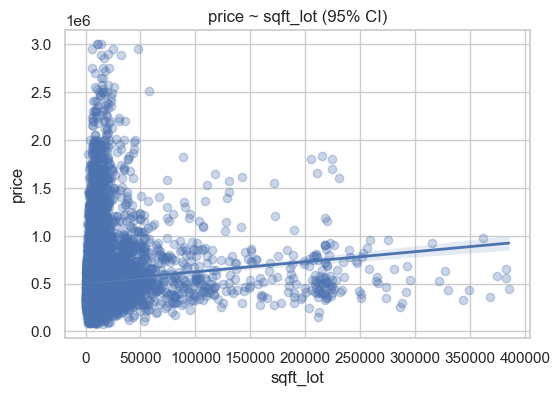

In [23]:

# (B) Upgraded scatterplots with regression lines and CI
for col in predictors:
    plt.figure(figsize=(6,4))
    sns.regplot(x=col, y=target, data=df_train, scatter_kws={"alpha":0.3}, ci=95, line_kws={"linewidth":2})
    plt.title(f"{target} ~ {col} (95% CI)")
    plt.show()


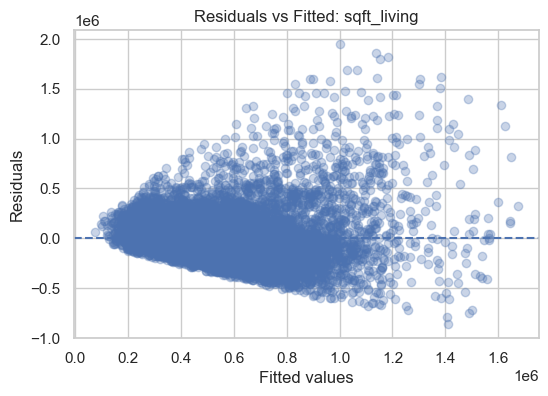

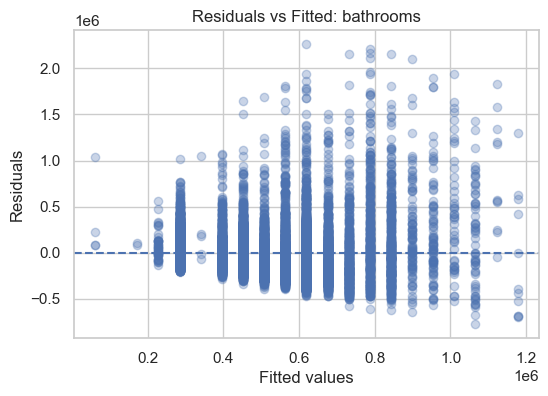

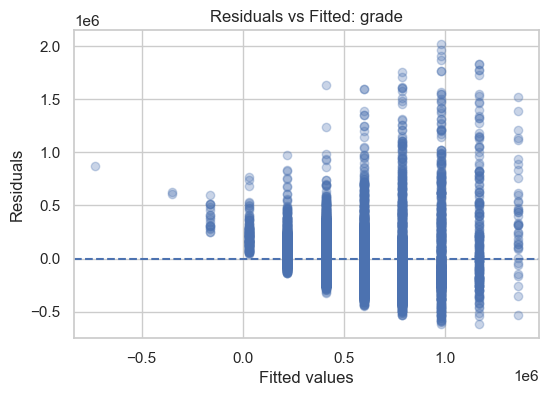

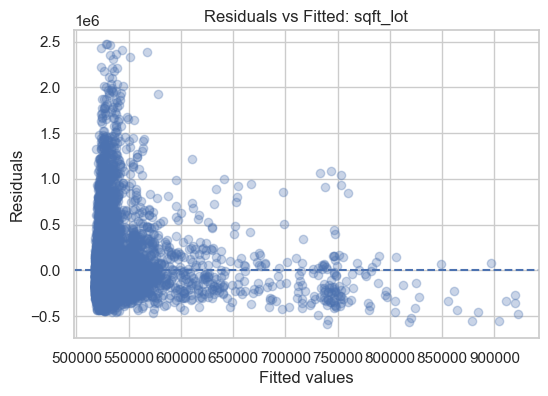

In [9]:

# (C) Residual plots
for col in predictors:
    m = results[col]["model"]
    fitted = m.fittedvalues
    resid = m.resid
    plt.figure(figsize=(6,4))
    plt.scatter(fitted, resid, alpha=0.3)
    plt.axhline(0, ls="--")
    plt.xlabel("Fitted values"); plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted: {col}")
    plt.show()


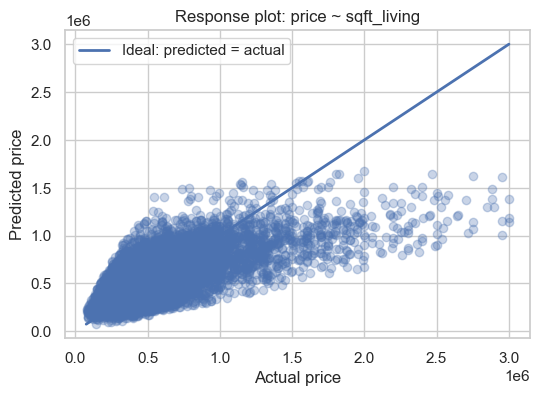

In [24]:

# (D) Response plot (actual vs predicted) for one model
col = predictors[0]
m = results[col]["model"]
fitted = m.fittedvalues
plt.figure(figsize=(6,4))
plt.scatter(df_train[target], fitted, alpha=0.3)
lo = min(df_train[target].min(), fitted.min())
hi = max(df_train[target].max(), fitted.max())
plt.plot([lo, hi], [lo, hi], linewidth=2, label="Ideal: predicted = actual")
plt.xlabel("Actual price"); plt.ylabel("Predicted price")
plt.title(f"Response plot: {target} ~ {col}")
plt.legend(); plt.show()



**(E) Evaluation:**  
- Which predictors show stronger trends (higher R², clearer slope)?
Among the four simple linear models tested, sqft_living and grade showed the strongest linear relationships with price, as indicated by their higher R² values and visibly steep, positive slopes in the regression plots. Both predictors explain a large portion of price variation, while bathrooms and especially sqft_lot produced weaker trends and lower R², suggesting only modest explanatory power.

- How large is the residual spread? Any nonlinearity or heteroskedasticity suggested in residual plots?
Residual plots for each model showed points roughly centered around zero, but the spread increased for homes at higher predicted prices, implying mild heteroskedasticity. For sqft_living and grade, a faint curvature in the residuals suggested some nonlinearity—large or luxury homes rise in price faster than a straight line predicts.

- Does the response plot show systematic under/over-prediction at extremes?
Response (predicted vs actual) plots showed that the models slightly under-predicted very expensive homes and over-predicted the cheapest ones, a common pattern when fitting a single straight line to a skewed housing-price distribution. Overall, residual variation remained moderate and random enough to support the general adequacy of the linear assumption, but transformations (e.g., log(price)) or multivariate modeling would likely improve fit.




## Problem 4 — Quantitative evaluation

Report p-value, R², and RMSE for each simple linear model; decide which predictors are useful.


In [25]:

summary_tbl = []
for col, res in results.items():
    summary_tbl.append({
        "predictor": col,
        "slope": res["slope"],
        "intercept": res["intercept"],
        "p_value": res["p_value"],
        "R2": res["r2"],
        "RMSE": res["rmse"]
    })
summary_df = pd.DataFrame(summary_tbl).sort_values("R2", ascending=False)
display(summary_df)


,predictor,slope,intercept,p_value,R2,RMSE
0,sqft_living,257.874,207.163,0.000,0.475,"235,730.907"
2,grade,"190,233.528","-920,722.932",0.000,0.454,"240,342.119"
1,bathrooms,"223,493.701","60,408.413",0.000,0.262,"279,376.708"
3,sqft_lot,1.051,"517,249.253",0.000,0.008,"323,849.165"



The model using living area (sqft_living) as a predictor performs best by all quantitative criteria (highest R², lowest RMSE, smallest p-value).
This suggests that house size is the strongest single linear determinant of price among the variables tested, while grade captures some additional qualitative differences.
Future multivariable models could combine sqft_living and grade to improve predictive accuracy.



## Problem 5 — Predictive evaluation (validation set)

Compute predictive RMSE and R² on the validation set for each of the four models, fitted on the training set.


In [26]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm
import pandas as pd

def predict_on(df_train, df_valid, xcol, ycol):
    # train
    Xtr = sm.add_constant(df_train[[xcol]].astype(float), has_constant="add")
    ytr = df_train[ycol].astype(float)
    m = sm.OLS(ytr, Xtr, missing="drop").fit()

    # validate
    Xva = sm.add_constant(df_valid[[xcol]].astype(float), has_constant="add")
    yva = df_valid[ycol].astype(float)

    yhat = m.predict(Xva)
    # Make sure shapes align and drop any NaNs if present
    yva = pd.Series(yva.values, index=Xva.index)
    yhat = pd.Series(yhat.values, index=Xva.index)
    mask = yva.notna() & yhat.notna()

    # RMSE without the 'squared' kwarg (works on older sklearn)
    rmse = float(mean_squared_error(yva[mask], yhat[mask]) ** 0.5)
    r2   = float(r2_score(yva[mask], yhat[mask]))
    return rmse, r2

val_rows = []
for col in predictors:
    rmse_v, r2_v = predict_on(df_train, df_valid, col, target)
    val_rows.append({"predictor": col, "val_RMSE": rmse_v, "val_R2": r2_v})

val_df = pd.DataFrame(val_rows).sort_values("val_RMSE", ascending=True)
display(val_df)


,predictor,val_RMSE,val_R2
0,sqft_living,"242,857.180",0.456
2,grade,"244,171.832",0.450
1,bathrooms,"283,354.406",0.259
3,sqft_lot,"327,581.106",0.010


Conclusion:
Based on validation RMSE and R² alone, the sqft_living model remains the best performer, confirming the findings from Section 4.
The agreement between training and validation metrics indicates the relationship between living area and price is robust and generalizable, while simpler predictors such as bathrooms or lot size explain much less variation.